# Analysis of Experimental Data

In [40]:
# Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from collections import defaultdict

# Association


### Load and prepare Data

In [41]:
# TODO Interpretation: Compare top responses Human vs AI, Compare Top R1 cues vs random cues, Alles AI mean vs AI models solo
# TODO: Check if everything is done Mister P

In [44]:
# Read Data
snow_complete_df = pd.read_csv("./../data/datasets/SWOW-EN18/SWOW-EN.complete.20180827.csv", usecols=["cue", "R1", "R2", "R3"])

cues_df = pd.read_csv("./../data/datasets/top_100_cues_by_R1.csv", usecols=["cue"])
cues_random_100_df = pd.read_csv("./../data/datasets/cues_random_100.csv", usecols=["cue"])

snow_cues_top_100_df = snow_complete_df[snow_complete_df["cue"].isin(cues_df["cue"])]
snow_cues_random_100_df = snow_complete_df[snow_complete_df["cue"].isin(cues_random_100_df["cue"])]

# Results from the experiment
def load_results(folder_path):
    columns = ["model", "cue", "A1", "A2", "A3"]
    
    dfs = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path, usecols=columns)
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)


ai_top_100_df = load_results("./../data/results/association/top_100_r1")
ai_random_100_df = load_results("./../data/results/association/random_100")

ai_top_100_df.rename(
    columns={"A1": "R1", "A2": "R2", "A3": "R3"},
    inplace=True
)

ai_random_100_df.rename(
    columns={"A1": "R1", "A2": "R2", "A3": "R3"},
    inplace=True
)


In [45]:
# Merge Snow R1 and R123
snow_r1_df = pd.read_csv("./../data/datasets/SWOW-EN18/strength.SWOW-EN.R1.20180827.csv", usecols=["cue", "response", "R1", "N", "R1.Strength"], sep="\t", quoting=3)
snow_r123_df = pd.read_csv("./../data/datasets/SWOW-EN18/strength.SWOW-EN.R123.20180827.csv", usecols=["cue", "response", "R123", "N", "R123.Strength"], sep="\t", quoting=3)

# Rename N columns to avoid collision
snow_r123_df = snow_r123_df.rename(
    columns={"N": "R123.N"},
)
snow_r1_df = snow_r1_df.rename(
    columns={"N": "R1.N"},
)

# Merge on cue and response
snow_r_123_merged_df = snow_r123_df.merge(
    snow_r1_df[['cue', 'response', 'R1', 'R1.N', 'R1.Strength']],
    on=['cue', 'response'],
    how='left'
)

snow_r_123_merged_df = snow_r_123_merged_df.fillna(0)
snow_r_123_merged_df = snow_r_123_merged_df.sort_values(by="cue", key=lambda s: s.str.lower())

snow_r_123_merged_df.to_csv("./../data/results/association/analysis/snow_r_123_merged.csv", index=False)

In [46]:
# Get R1 score, R123 score per cue/response pair
def get_R1_and_R123_scores(df):
    # Get all unique cue-response pairs
    pairs_list = []
    for col in ["R1", "R2", "R3"]:
        temp = df[["cue", col]].rename(columns={col: "response"})
        pairs_list.append(temp)
    all_pairs = pd.concat(pairs_list).dropna().drop_duplicates().reset_index(drop=True)

    # Remove invalid responses
    #invalid_rows = all_pairs[all_pairs["response"] == "invalid Response"]
    #unwanted = ["No more responses", "Unknown word"]
    #all_pairs = all_pairs[~all_pairs["response"].isin(unwanted)]

    # Total number of entries per cue
    cue_counts = df.groupby("cue").size().rename("R1.N").reset_index()

    # Count R1 occurrences 
    r1_counts = (
        df.groupby(["cue", "R1"])
        .size()
        .reset_index()
        .rename(columns={"R1": "response", 0: "R1", "size": "R1"})
    )
    r1_counts = r1_counts.rename(columns={0: "R1"}) if "0" in r1_counts.columns else r1_counts

    # Count R123 occurrences 
    r123_list = []
    for cue, group in df.groupby("cue"):
        values = group[["R1", "R2", "R3"]].values.flatten()
        values = [v for v in values if pd.notna(v)]
        vc = pd.Series(values).value_counts()
        temp = pd.DataFrame({"cue": cue, "response": vc.index, "R123": vc.values})
        r123_list.append(temp)
    r123_counts = pd.concat(r123_list, ignore_index=True)

    # Merge r1 and r123
    result = all_pairs.merge(r1_counts, on=["cue", "response"], how="left") \
        .merge(r123_counts, on=["cue", "response"], how="left") \
        .merge(cue_counts, on="cue", how="left")

    result["R1"] = result["R1"].fillna(0).astype(int)

    # Compute strengths
    result["R1.Strength"] = result["R1"] / result["R1.N"]
    result["R123.N"] = result["R1.N"] * 3 # Magic Number: 3 responses per cue
    result["R123.Strength"] = result["R123"] / result["R123.N"]

    result = result[
        [
            "cue",
            "response",
            "R1",
            "R1.N",
            "R1.Strength",
            "R123",
            "R123.N",
            "R123.Strength",
        ]
    ]

    return result

snow_cues_top_100_df = snow_cues_top_100_df.sort_values(by="cue", key=lambda s: s.str.lower())
ai_top_100_df = ai_top_100_df.sort_values(by="cue", key=lambda s: s.str.lower())
ai_random_100_df = ai_random_100_df.sort_values(by="cue", key=lambda s: s.str.lower())

ai_top_100_scores_df = get_R1_and_R123_scores(ai_top_100_df)
ai_random_100_scores_df = get_R1_and_R123_scores(ai_random_100_df)

ai_top_100_scores_df = ai_top_100_scores_df.sort_values(by="cue", key=lambda s: s.str.lower())
ai_random_100_scores_df = ai_random_100_scores_df.sort_values(by="cue", key=lambda s: s.str.lower())

ai_top_100_scores_df.to_csv("./../data/results/association/analysis/ai_top_100_scores.csv", index=False)
ai_random_100_scores_df.to_csv("./../data/results/association/analysis/ai_random_100_scores.csv", index=False)

### Plot Error Rates
How many invalid responses or "No more responses" were given by each model?

In [47]:
allowed_top_100_cues = set(ai_top_100_scores_df['cue'])
allowed_random_100_cues = set(ai_random_100_scores_df['cue'])

# Keep only rows whose cue is in the allowed list
snow_r_123_top_100_df = snow_r_123_merged_df[
    snow_r_123_merged_df['cue'].isin(allowed_top_100_cues)
]
snow_r_123_top_100_df.to_csv("./../data/results/association/analysis/snow_r_123_top_100_df.csv", index=False)

snow_r_123_random_100_df = snow_r_123_merged_df[
    snow_r_123_merged_df['cue'].isin(allowed_random_100_cues)
]
snow_r_123_random_100_df.to_csv("./../data/results/association/analysis/snow_r_123_random_100_df.csv", index=False)

In [48]:
def save_plot(name, path, plt):
    output_dir = Path(path)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    plt.savefig(output_dir / name, dpi=300, bbox_inches="tight")

In [49]:
def order_df(df):
    model_order = [
        'qwen3:0.6b',
        'qwen3:1.7b',
        'qwen3:8b',
        'qwen3:14b',
        'qwen3:30b',
        'gemma3:270m',
        'gemma3:1b',
        'gemma3:4b',
        'gemma3:12b',
        'gemma3:27b'
    ]

    # Models in and not in the order list
    in_order = df[df["model"].isin(model_order)]
    not_in_order = df[~df["model"].isin(model_order)]

    # Sort the in-order models according to your list
    in_order = (
        in_order
        .assign(_order=in_order["model"].map({m: i for i, m in enumerate(model_order)}))
        .sort_values("_order")
        .drop(columns="_order")
    )

    # Final DataFrame: others first, ordered ones after
    df_plot = pd.concat([not_in_order, in_order], ignore_index=True)

    return df_plot

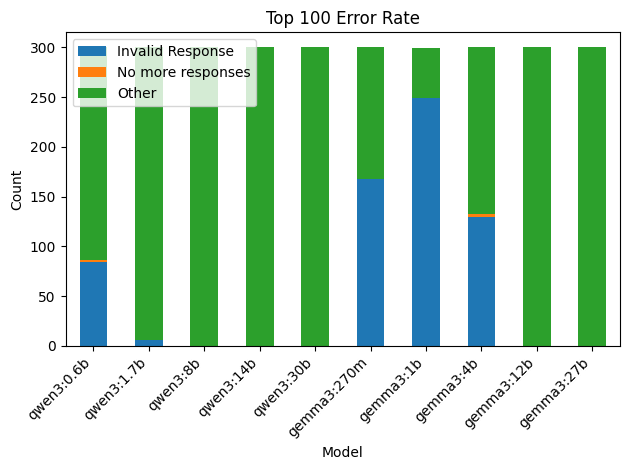

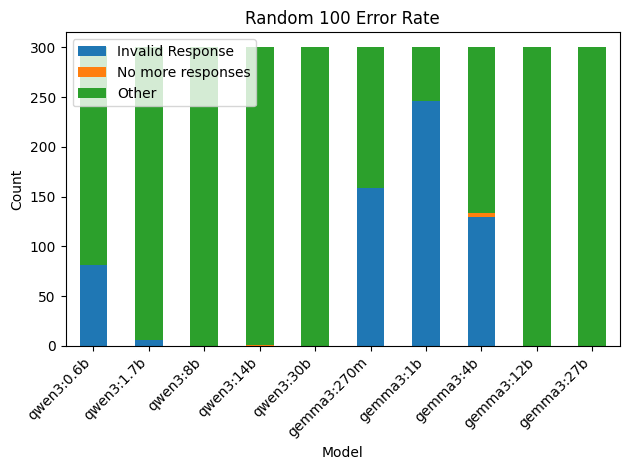

In [58]:
# Error Rate per Model
def show_error_rate(plot_name, data):
    answer_cols = ["R1", "R2", "R3"]
    
    summary = (
        data
        .melt(
            id_vars="model",
            value_vars=answer_cols,
            value_name="answer"
        )
        .assign(
            Invalid=lambda d: d["answer"] == "Invalid Response",
            NoMore=lambda d: d["answer"] == "No more responses"
        )
        .groupby("model", as_index=False)
        .agg(
            **{
                "Invalid Response": ("Invalid", "sum"),
                "No more responses": ("NoMore", "sum"),
                "Total": ("answer", "count"),
            }
        )
    )
    
    summary["Other"] = (
        summary["Total"]
        - summary["Invalid Response"]
        - summary["No more responses"]
    )
    
    summary = summary[
        ["model", "Invalid Response", "No more responses", "Other"]
    ]
    
    # Plot
    summary = order_df(summary)
    summary.plot(kind="bar", stacked=True)


    models = summary["model"]
    x = np.arange(len(models))
    plt.xticks(x, models, rotation=45, ha="right")
    
    plt.xlabel("Model")
    plt.ylabel("Count")
    plt.title(plot_name)
    plt.tight_layout()
    save_plot(plot_name.lower().replace(" ", "_"), "./../data/results/association/analysis", plt)
    
    plt.show()
    plt.close()
    
show_error_rate("Top 100 Error Rate", ai_top_100_df)
show_error_rate("Random 100 Error Rate", ai_random_100_df)

### Compare Top Responses of Humans vs AI

In [59]:
# Merge ai_random and ai_top into snow123 merged
ai_top_100_scores_df_renamed = ai_top_100_scores_df.rename(
    columns={
        "R1": "TOP.R1",
        "R1.N": "TOP.R1.N",
        "R1.Strength": "TOP.R1.Strength",
        "R123": "TOP.R123",
        "R123.N": "TOP.R123.N",
        "R123.Strength": "TOP.R123.Strength",
    }
)

ai_random_100_scores_df_renamed = ai_random_100_scores_df.rename(
    columns={
        "R1": "RANDOM.R1",
        "R1.N": "RANDOM.R1.N",
        "R1.Strength": "RANDOM.R1.Strength",
        "R123": "RANDOM.R123",
        "R123.N": "RANDOM.R123.N",
        "R123.Strength": "RANDOM.R123.Strength",
    }
)

snow_r_123_merged_df_renamed = snow_r_123_merged_df.rename(
    columns={
        "R1": "HUMAN.R1",
        "R1.N": "HUMAN.R1.N",
        "R1.Strength": "HUMAN.R1.Strength",
        "R123": "HUMAN.R123",
        "R123.N": "HUMAN.R123.N",
        "R123.Strength": "HUMAN.R123.Strength",
    }
)

merged_all_scores = snow_r_123_merged_df_renamed.merge(
    ai_top_100_scores_df_renamed[['cue', 'response', 'TOP.R1', 'TOP.R1.N', 'TOP.R1.Strength', 'TOP.R123', 'TOP.R123.N', 'TOP.R123.Strength']],
    on=['cue', 'response'],
    how='left'
)

merged_all_scores = merged_all_scores.merge(
    ai_random_100_scores_df_renamed[['cue', 'response', 'RANDOM.R1', 'RANDOM.R1.N', 'RANDOM.R1.Strength', 'RANDOM.R123', 'RANDOM.R123.N', 'RANDOM.R123.Strength']],
    on=['cue', 'response'],
    how='left'
)

merged_all_scores = merged_all_scores.fillna(0)
merged_all_scores = merged_all_scores.sort_values(by="cue", key=lambda s: s.str.lower())

merged_all_scores.to_csv("./../data/results/association/analysis/merged_all_scores.csv", index=False)

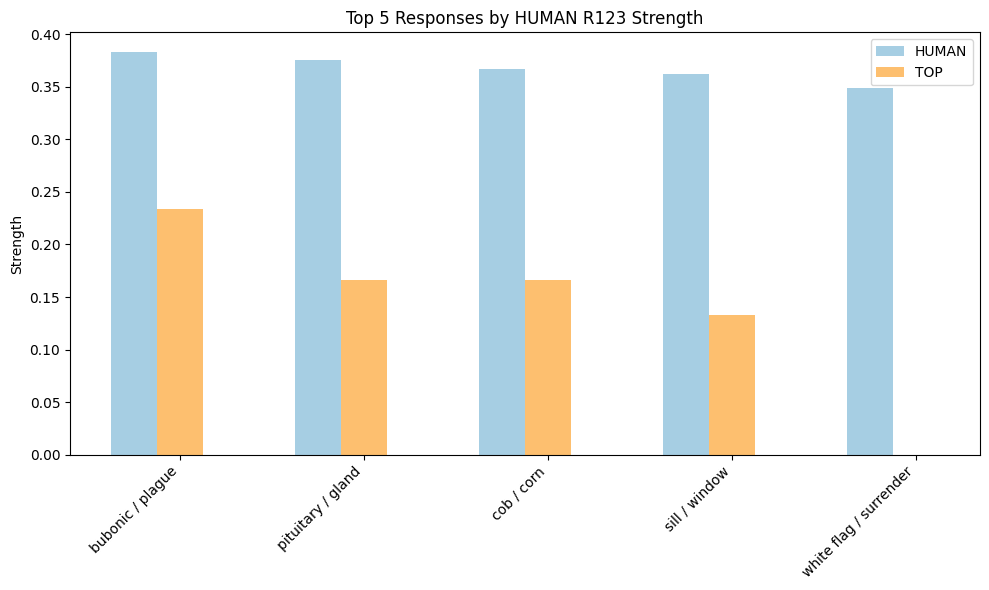

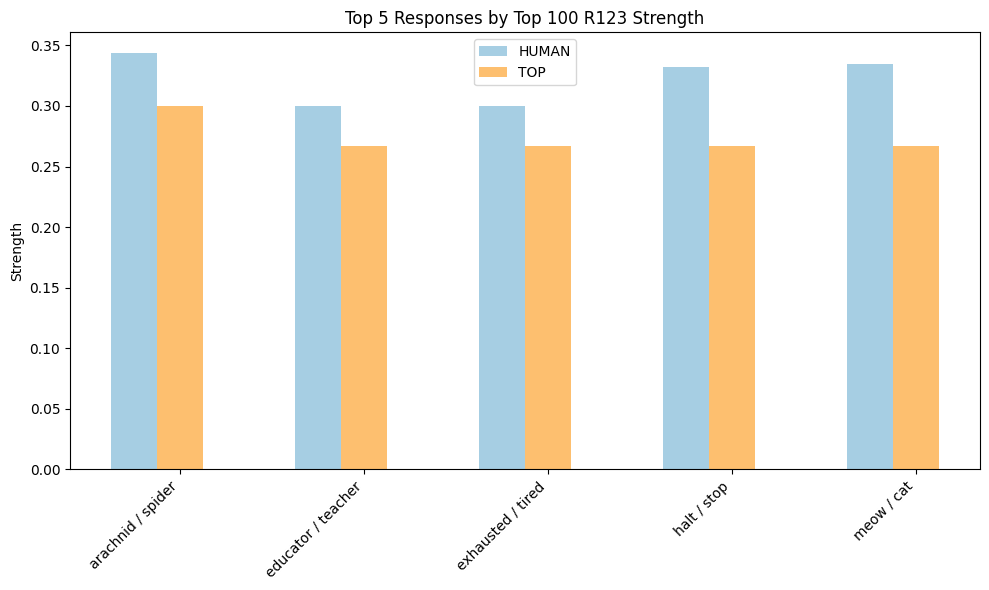

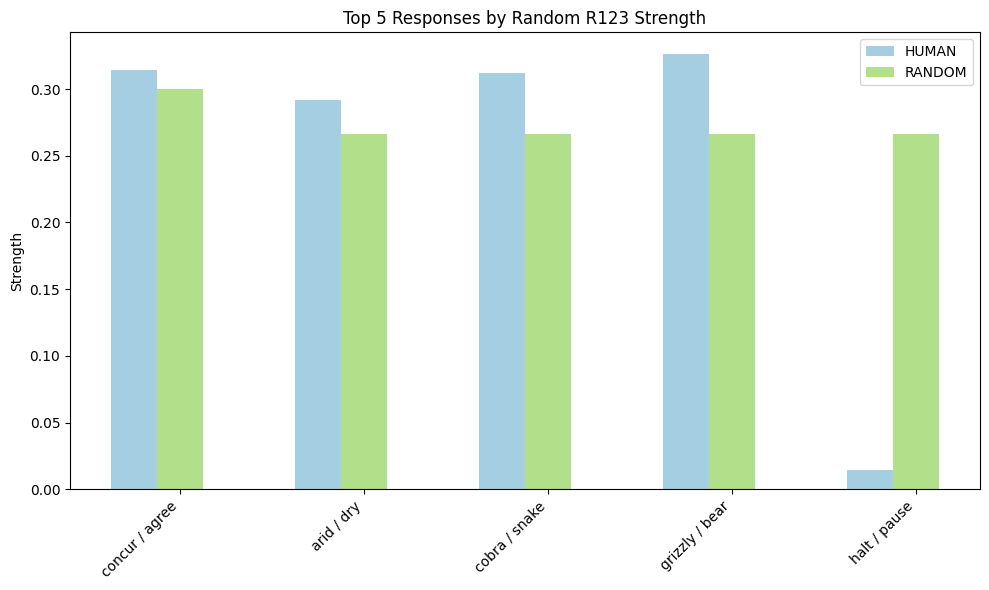

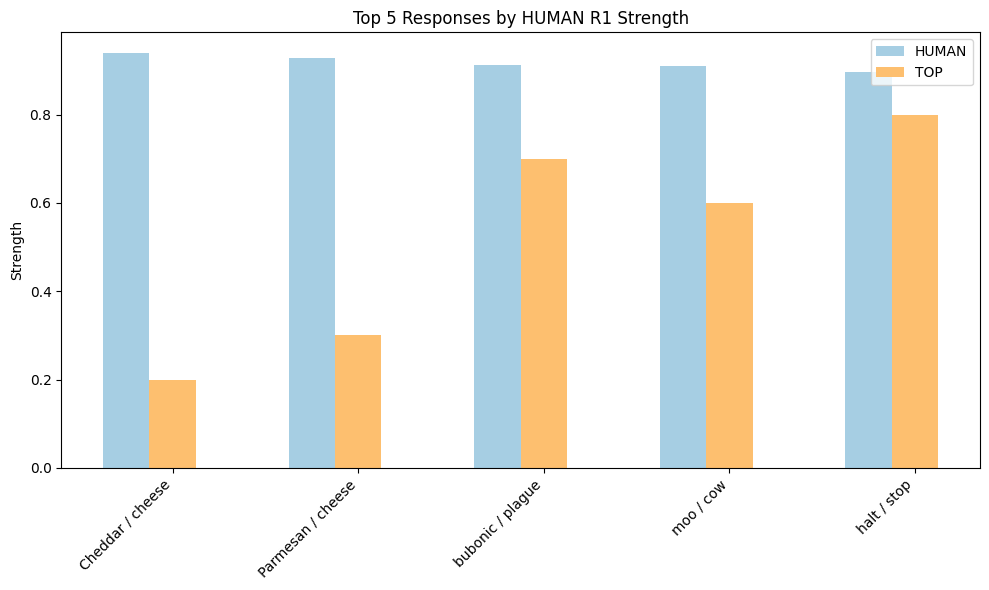

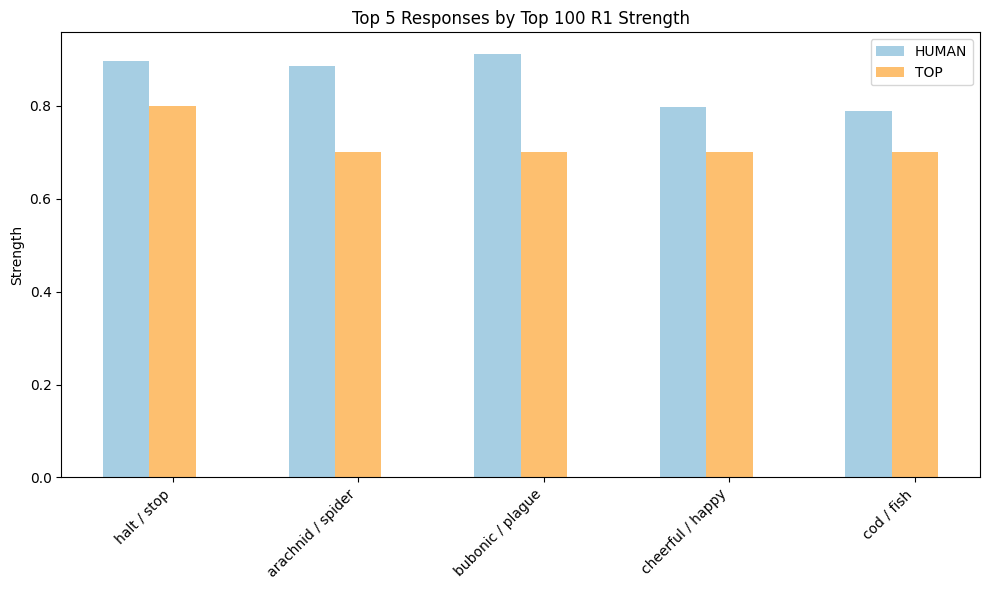

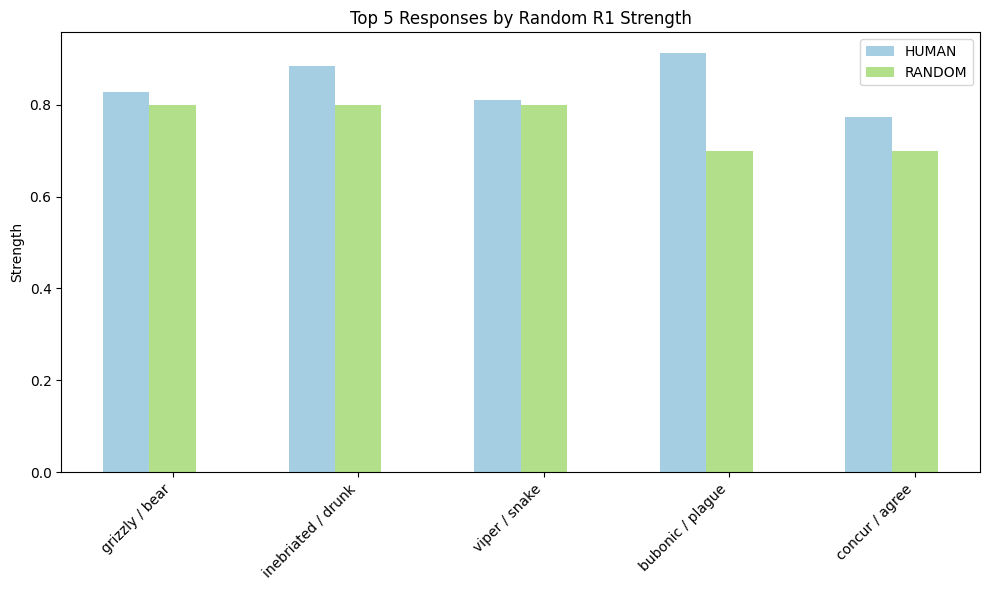

In [60]:
def compare_top_cues(plot_name, sort_by, strength_type, top_n=5):
    bar_colors = {
        "HUMAN": "#a6cee3",
        "TOP": "#fdbf6f",
        "RANDOM": "#b2df8a"
    }
    
    strength_cols = [f"HUMAN.{strength_type}.Strength"]
    
    # Its very unlikely that RANDOM cues/responses are included in TOP, and if yes, they should be the same
    # So include only Human for TOP and RANDOM and only TOP for HUMAN  
    if sort_by == "HUMAN":
        strength_cols.append(f"TOP.{strength_type}.Strength")
    else:
        strength_cols.append(f"{sort_by}.{strength_type}.Strength")
                
    # Get top_n rows
    top_entries = merged_all_scores.nlargest(top_n, f"{sort_by}.{strength_type}.Strength").copy()
    
    # cue and response label
    top_entries["label"] = top_entries["cue"] + " / " + top_entries["response"]
    
    # Plot
    x = np.arange(len(top_entries))
    width = 0.25 
    
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.bar(x - width, top_entries[f"HUMAN.{strength_type}.Strength"], width, label="HUMAN", color=bar_colors["HUMAN"])
    
    if sort_by == "HUMAN":
        ax.bar(x, top_entries[f"TOP.{strength_type}.Strength"], width, label="TOP", color=bar_colors["TOP"])
    else:
        ax.bar(x, top_entries[f"{sort_by}.{strength_type}.Strength"], width, label=sort_by, color=bar_colors[sort_by])
    
    
    ax.set_xticks(x)
    ax.set_xticklabels(top_entries["label"], rotation=45, ha="right")
    ax.set_ylabel("Strength")
    ax.set_title(plot_name)
    ax.legend()
    
    plt.tight_layout()
    save_plot(plot_name.lower().replace(" ", "_"), "./../data/results/association/analysis", plt)
    
    plt.show()
    plt.close()
    
compare_top_cues("Top 5 Responses by HUMAN R123 Strength", "HUMAN", "R123", top_n=5)
compare_top_cues("Top 5 Responses by Top 100 R123 Strength", "TOP", "R123",top_n=5)
compare_top_cues("Top 5 Responses by Random R123 Strength", "RANDOM", "R123",top_n=5)

compare_top_cues("Top 5 Responses by HUMAN R1 Strength", "HUMAN", "R1", top_n=5)
compare_top_cues("Top 5 Responses by Top 100 R1 Strength", "TOP", "R1",top_n=5)
compare_top_cues("Top 5 Responses by Random R1 Strength", "RANDOM", "R1",top_n=5)

### AI Similarity to Human 

In [61]:
# Get all R1 and R123 words for each cue in snow_complete_df
def build_cue_response_lookup(df):
    lookup = defaultdict(lambda: {"R1": set(), "R123": set()})
    
    for _, row in df.iterrows():
        cue = row["cue"]
    
        # R1 responses
        if pd.notna(row["R1"]):
            lookup[cue]["R1"].add(row["R1"])
            lookup[cue]["R123"].add(row["R1"])
    
        # R2 + R3 responses
        for col in ["R2", "R3"]:
            if pd.notna(row[col]):
                lookup[cue]["R123"].add(row[col])
    return lookup

snow_top_100_lookup = build_cue_response_lookup(snow_cues_top_100_df)
snow_random_100_lookup = build_cue_response_lookup(snow_cues_random_100_df)

In [62]:
# Compute Similarity
def compute_similarity(ai_df, snow_lookup):
    columns = ["model", "R1.Similarity", "R123.Similarity"]
    df = pd.DataFrame(columns=columns)
    
    for model in ai_df["model"].unique():
        model_data = ai_df[ai_df["model"] == model]
        
        total_r1 = 0
        matched_r1 = 0
        total_r123 = 0
        matched_r123 = 0
        
        for _, row in model_data.iterrows():
            cue = row["cue"]
            responses = [row["R1"], row["R2"], row["R3"]]
            
            if cue in snow_lookup:
                snow_r1_set = snow_lookup[cue]["R1"]
                snow_r123_set = snow_lookup[cue]["R123"]
                
                # R1 similarity
                if pd.notna(row["R1"]):
                    total_r1 += 1
                    if row["R1"] in snow_r1_set:
                        matched_r1 += 1
                
                # R123 similarity
                for resp in responses:
                    if pd.notna(resp):
                        total_r123 += 1
                        if resp in snow_r123_set:
                            matched_r123 += 1
        
        r1_similarity = matched_r1 / total_r1 if total_r1 > 0 else 0
        r123_similarity = matched_r123 / total_r123 if total_r123 > 0 else 0
        
        df.loc[len(df)] = {
            "model": model,
            "R1.Similarity": r1_similarity,
            "R123.Similarity": r123_similarity,
        }
        
    return df

top_100_similarity_df = compute_similarity(ai_top_100_df, snow_top_100_lookup)
random_100_similarity_df = compute_similarity(ai_random_100_df, snow_random_100_lookup)

print(top_100_similarity_df.head(2))
print(random_100_similarity_df.head(2))

        model  R1.Similarity  R123.Similarity
0   gemma3:1b       0.000000         0.065292
1  gemma3:27b       0.927835         0.862543
        model  R1.Similarity  R123.Similarity
0   gemma3:1b              0                0
1  gemma3:27b              0                0


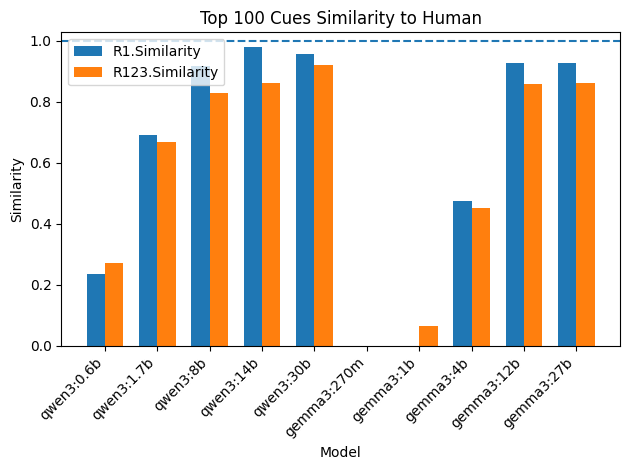

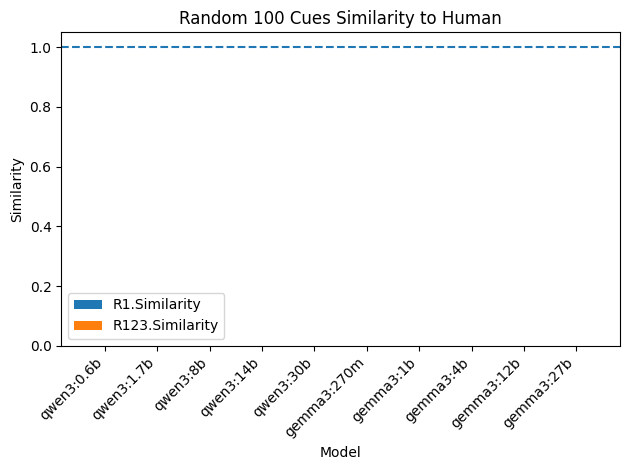

In [64]:
def plot_similarity(df, plot_name):
    df_sorted = order_df(df)
    
    models = df_sorted["model"]
    r1 = df_sorted["R1.Similarity"]
    r123 = df_sorted["R123.Similarity"]
    
    x = np.arange(len(models))   # label locations
    width = 0.35                 # width of the bars
    
    plt.figure()
    plt.bar(x - width/2, r1, width, label="R1.Similarity")
    plt.bar(x + width/2, r123, width, label="R123.Similarity")
    
    plt.axhline(y=1, linestyle="--")
    
    plt.xticks(x, models, rotation=45, ha="right")
    plt.xlabel("Model")
    plt.ylabel("Similarity")
    plt.title(plot_name)
    plt.legend()
    
    plt.tight_layout()
    save_plot(plot_name.lower().replace(" ", "_"), "./../data/results/association/analysis", plt)
    
    plt.show()
    plt.close()
    
plot_similarity(top_100_similarity_df, "Top 100 Cues Similarity to Human")
plot_similarity(random_100_similarity_df, "Random 100 Cues Similarity to Human")

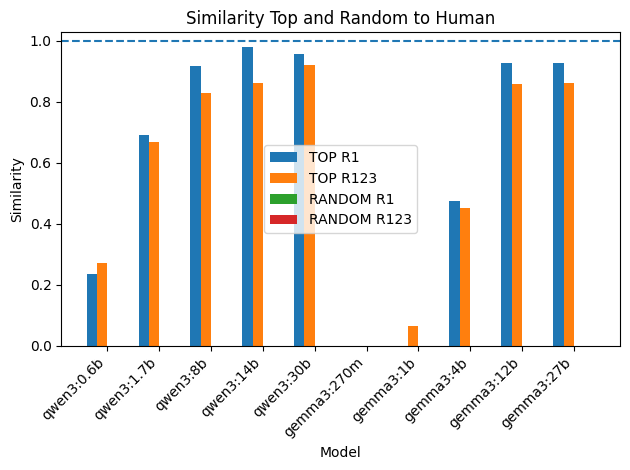

In [66]:
# Merge top and random to display all in one plot
top_100_similarity_df_renamed = top_100_similarity_df.rename(
    columns={
        "R1.Similarity": "TOP.R1.Similarity",
        "R123.Similarity": "TOP.R123.Similarity",
    }
)

random_100_similarity_df_renamed = random_100_similarity_df.rename(
    columns={
        "R1.Similarity": "RANDOM.R1.Similarity",
        "R123.Similarity": "RANDOM.R123.Similarity",
    }
)

merged_similarity_df = top_100_similarity_df_renamed.merge(
    random_100_similarity_df_renamed,
    on="model",
    how="inner"
)

def plot_similarity_across_top_random(df, plot_name):
    df_sorted = order_df(df)
    
    models = df_sorted["model"]
    top_r1 = df_sorted["TOP.R1.Similarity"]
    top_r123 = df_sorted["TOP.R123.Similarity"]
    random_r1 = df_sorted["RANDOM.R1.Similarity"]
    random_r123 = df_sorted["RANDOM.R123.Similarity"]
    
    x = np.arange(len(models))
    width = 0.2  # smaller width for 4 bars
    
    plt.figure()
    
    plt.bar(x - 1.5*width, top_r1, width, label="TOP R1")
    plt.bar(x - 0.5*width, top_r123, width, label="TOP R123")
    plt.bar(x + 0.5*width, random_r1, width, label="RANDOM R1")
    plt.bar(x + 1.5*width, random_r123, width, label="RANDOM R123")
    
    plt.axhline(y=1, linestyle="--")
    
    plt.xticks(x, models, rotation=45, ha="right")
    plt.xlabel("Model")
    plt.ylabel("Similarity")
    plt.title(plot_name)
    plt.legend()
    
    plt.tight_layout()
    save_plot(plot_name.lower().replace(" ", "_"), "./../data/results/association/analysis", plt)
    
    plt.show()
    plt.close()
    
plot_similarity_across_top_random(merged_similarity_df, "Similarity Top and Random to Human")

## Similarity Rating

In [67]:
# TODO Interpretation: Error Rate (n.a. responses or wrong output format), Mean vs Models, 1-shot vs 4-shot, Mean vs Human Mean

In [68]:
# Read Data
wordsim353_df = pd.read_csv("./../data/datasets/wordsim353.tsv", sep="\t",comment="#")

# Results from the experiment
def load_results(folder_path):    
    dfs = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

ai_1_shot = load_results("./../data/results/similarity/1-shot")
ai_4_shot = load_results("./../data/results/similarity/4-shot")

wordsim353_df["model"] = "Human"
wordsim353_df = wordsim353_df[["model", "Word 1", "Word 2", "Human (mean)"]].rename(
    columns={
        "Word 1": "w1",
        "Word 2": "w2",
        "Human (mean)": "rating",
    }
)

print(wordsim353_df.head(2))
print(ai_1_shot.head(2))
print(ai_4_shot.head(2))

   model     w1   w2  rating
0  Human   love  sex    6.77
1  Human  tiger  cat    7.35
        model     w1   w2 rating
0  gemma3:12b   love  sex      4
1  gemma3:12b  tiger  cat      7
        model     w1   w2 rating
0  gemma3:12b   love  sex      6
1  gemma3:12b  tiger  cat      8


### Error Rate
n.a. responses or wrong output format

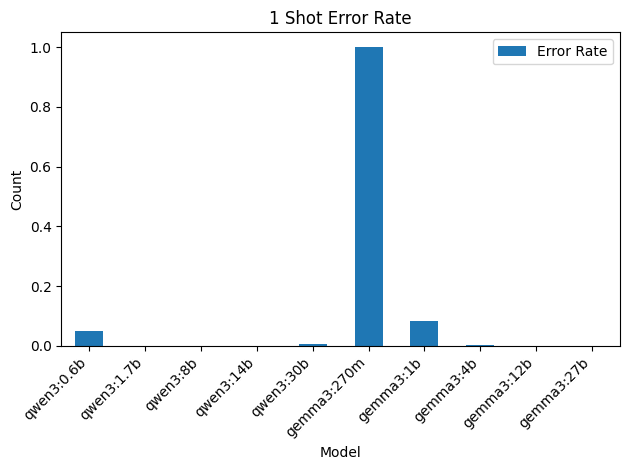

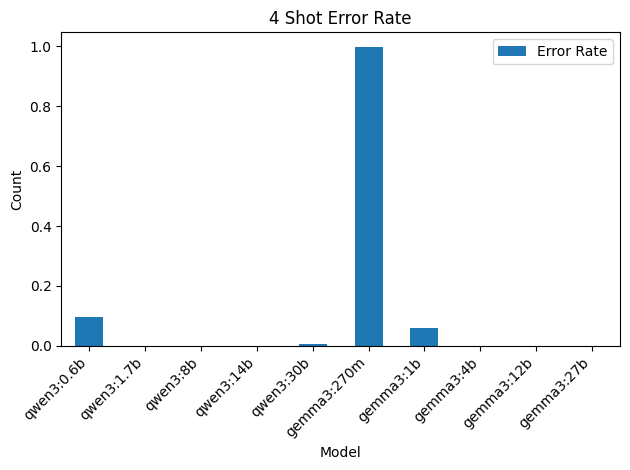

In [70]:
# Error Rate per Model
def get_similarity_error_rate_summary(data):
    summary = (
        data
        .melt(
            id_vars="model",
            value_vars=["rating"],
            value_name="Invalid Responses"
        )
        .assign(
            Invalid=lambda d: d["Invalid Responses"] == "Invalid Response"
        )
        .groupby("model", as_index=False)
        .agg(
            **{
                "Invalid Responses": ("Invalid", "sum"),
                "Total": ("Invalid Responses", "count"),
            }
        )
    )
    
    summary["Error Rate"] = (
        summary["Invalid Responses"] / summary["Total"]
    )
    
    summary = summary.drop(columns=["Invalid Responses"])
    summary = summary.drop(columns=["Total"])
    
    return summary

def show_similarity_error_rate(plot_name, data):
    summary = get_similarity_error_rate_summary(data)
    
    # Plot
    summary = order_df(summary)
    summary.plot(kind="bar", stacked=True)
    
    models = summary["model"]
    
    x = np.arange(len(models))  # x locations for the bars
    
    plt.xticks(x, models, rotation=45, ha="right")
    plt.xlabel("Model")
    plt.ylabel("Count")
    plt.title(plot_name)
    plt.tight_layout()
    save_plot(plot_name.lower().replace(" ", "_"), "./../data/results/similarity/analysis", plt)
    
    plt.show()
    plt.close()
    
show_similarity_error_rate("1 Shot Error Rate", ai_1_shot)
show_similarity_error_rate("4 Shot Error Rate", ai_4_shot)

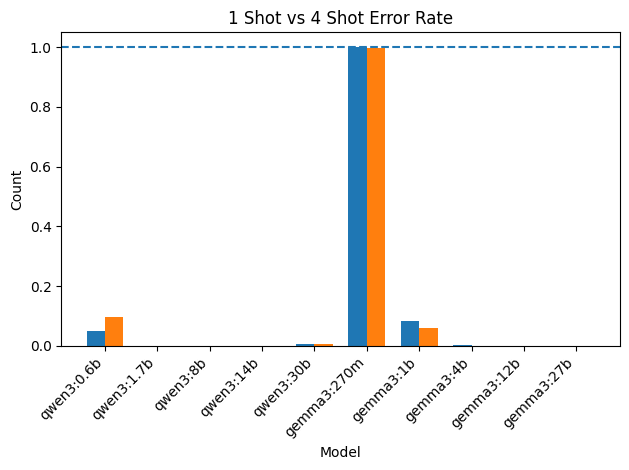

In [71]:
# Plot 1-shot and 4-shot in one plot    
def show_similarity_error_rate_one_plot(plot_name, data_1_shot, data_4_shot):
    summary_1_shot = get_similarity_error_rate_summary(data_1_shot)
    summary_4_shot = get_similarity_error_rate_summary(data_4_shot)
    
    # Rename column to avoid collision
    summary_1_shot = summary_1_shot[["model", "Error Rate"]].rename(
        columns={"Error Rate": "Error Rate 1-Shot"}
    )
    
    summary_4_shot = summary_4_shot[["model", "Error Rate"]].rename(
        columns={"Error Rate": "Error Rate 4-Shot"}
    )
    
    # Merge into one_shot_summary
    summary = summary_1_shot.merge(
        summary_4_shot,
        on="model",
        how="left"
    )    
    
    # Plot
    summary = order_df(summary)

    models = summary["model"]
    s_1_shot = summary["Error Rate 1-Shot"]
    s_4_shot = summary["Error Rate 4-Shot"]
        
    x = np.arange(len(models))   # label locations
    width = 0.35                 # width of the bars
    
    plt.figure()
    plt.bar(x - width/2, s_1_shot, width, label="Error Rate 1-Shot")
    plt.bar(x + width/2, s_4_shot, width, label="Error Rate 4-Shot")
    
    plt.axhline(y=1, linestyle="--")
    
    plt.xticks(x, models, rotation=45, ha="right")
    plt.xlabel("Model")
    plt.ylabel("Count")
    plt.title(plot_name)
    plt.tight_layout()
    save_plot(plot_name.lower().replace(" ", "_"), "./../data/results/similarity/analysis", plt)
    
    plt.show()
    plt.close()
    
show_similarity_error_rate_one_plot("1 Shot vs 4 Shot Error Rate", ai_1_shot, ai_4_shot)

### Comparison Human vs AI: Mean vs Models

In [72]:
# Compare mean of Models and Human
def get_mean_summary(data):
    # Filter out all invalid responses
    data = data[data["rating"] != "Invalid Response"]
    data.loc[:, "rating"] = pd.to_numeric(data["rating"], errors="coerce")
    
    summary = (
        data
        .groupby("model", as_index=False)
        .agg(
            MeanRating=("rating", "mean")
        )
    )
    
    return summary

mean_summary_human = get_mean_summary(wordsim353_df)
mean_summary_1_shot = get_mean_summary(ai_1_shot)
mean_summary_4_shot = get_mean_summary(ai_4_shot)

print(mean_summary_human.head(2))
print(mean_summary_1_shot.head(2))
print(mean_summary_4_shot.head(2))


   model  MeanRating
0  Human    5.855864
        model MeanRating
0  gemma3:12b   3.810198
1   gemma3:1b   7.476341
        model MeanRating
0  gemma3:12b   3.730878
1   gemma3:1b   7.366154


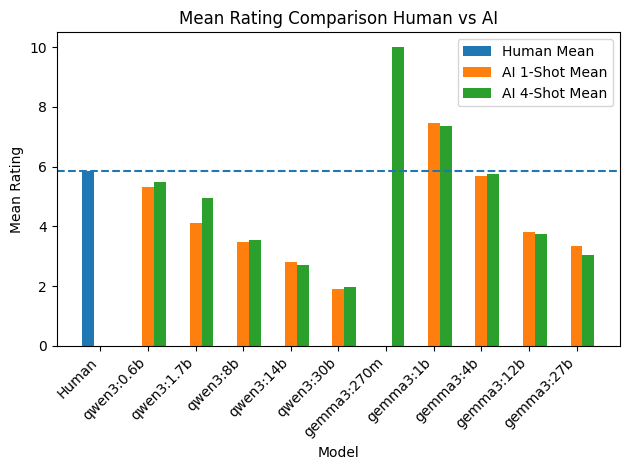

In [73]:
def plot_mean_comparison(plot_name, human_summary, ai_1_shot_summary, ai_4_shot_summary):
    # Merge all summaries
    merged_summary = human_summary.rename(
        columns={"MeanRating": "Human Mean"}
    ).merge(
        ai_1_shot_summary.rename(
            columns={"MeanRating": "AI 1-Shot Mean"}
        ),
        on="model",
        how="outer"
    ).merge(
        ai_4_shot_summary.rename(
            columns={"MeanRating": "AI 4-Shot Mean"}
        ),
        on="model",
        how="outer"
    )

    # Plot
    merged_summary = merged_summary.sort_values("Human Mean", ascending=True)
    merged_summary = order_df(merged_summary)

    models = merged_summary["model"]
    human_mean = merged_summary["Human Mean"]
    ai_1_shot_mean = merged_summary["AI 1-Shot Mean"]
    ai_4_shot_mean = merged_summary["AI 4-Shot Mean"]

    x = np.arange(len(models))
    width = 0.25  # smaller width for 3 bars

    plt.figure()

    plt.bar(x - width, human_mean, width, label="Human Mean")
    plt.bar(x, ai_1_shot_mean, width, label="AI 1-Shot Mean")
    plt.bar(x + width, ai_4_shot_mean, width, label="AI 4-Shot Mean")

    plt.axhline(y=human_mean[0], linestyle="--")

    plt.xticks(x, models, rotation=45, ha="right")
    plt.xlabel("Model")
    plt.ylabel("Mean Rating")
    plt.title(plot_name)
    plt.legend()

    plt.tight_layout()
    save_plot(plot_name.lower().replace(" ", "_"), "./../data/results/similarity/analysis", plt)

    plt.show()
    plt.close()

plot_mean_comparison("Mean Rating Comparison Human vs AI", mean_summary_human, mean_summary_1_shot, mean_summary_4_shot)

### Comparison Human vs AI: 1-shot vs 4-shot

### Comparison Human vs AI: Mean vs Human Mean

In [1]:
import subprocess

commands = [
    'ollama pull qwen3:1.7b',
    'ollama pull qwen3:8b',
    'ollama pull qwen3:14b',
    'ollama pull qwen3:30b',
    'ollama pull gemma3:270m',
    'ollama pull gemma3:1b',
    'ollama pull gemma3:4b',
    'ollama pull gemma3:12b',
    'ollama pull gemma3:27b'
]

for cmd in commands:
    subprocess.Popen(
        ["cmd", "/c", "start", "cmd", "/k", cmd],
        shell=True
    )